<a href="https://colab.research.google.com/github/Ademola-Olorunnisola/TB-Estimator/blob/main/UKF_EKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=27c4414b87cb0b635a59390407cf384910a86a4625e65c32d34e3d7c4c369b94
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.integrate import solve_ivp
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import warnings
warnings.filterwarnings('ignore')

## Parameters

In [7]:
N_pop   = 220e6

Lambda  = 37.9 / 1000 / 365   # Daily recruitment rate (birth rate per capita)
mu      = 11.5 / 1000 / 365   # Natural death rate per day
delta   = 268 / N_pop          # TB disease-induced death rate per day (~268 deaths/day)

#Control Inputs

In [8]:
alpha   = 0.01                 # u1: BCG vaccination rate (S → V)
tau     = 0.005                # u2: Treatment initiation rate (I → T)

#True Parameter Values

In [9]:
beta_true  = 0.15              # TB transmission rate
sigma_true = 0.40              # BCG vaccine inefficiency (60% efficacy)
gamma_true = 1 / 180           # Recovery rate (6-month treatment course)
eps_true   = 1 / 365           # Latency progression rate (~1 year latent period)
phi_true   = 0.03              # Exogenous reinfection rate (< beta)
rho_true   = 0.21 * gamma_true # Treatment failure rate (21% failure — NTLCP 2023)

# ODE SYSTEM

In [4]:
def sveirt_ode(t, x, params, u):
    """
    Full SVEIRT ODE system.
    x     : augmented state [S, V, E, I, T, R, beta, sigma, gamma, eps, phi, rho]
    params: fixed parameters (Lambda, mu, delta)
    u     : control inputs [alpha, tau]
    Returns dx/dt (12-dimensional)
    """
    S, V, E, I, T, R, beta, sigma, gamma, eps, phi, rho = x
    Lam, mu_, delta_ = params
    alpha_, tau_ = u

    # Force of infection (frequency-dependent, N=1 since normalised)
    lam = beta * I  # βI/N with N=1

    # Dynamic compartment ODEs
    dS = Lam - lam * S - alpha_ * S - mu_ * S
    dV = alpha_ * S - sigma * lam * V - mu_ * V
    dE = lam * S + sigma * lam * V + phi * R * I - (eps + mu_) * E
    dI = eps * E + rho * T - (tau_ + mu_ + delta_) * I
    dT = tau_ * I - (gamma + rho + mu_) * T
    dR = gamma * T - mu_ * R - phi * R * I

    # Static states — zero derivatives
    dbeta  = 0.0
    dsigma = 0.0
    dgamma = 0.0
    deps   = 0.0
    dphi   = 0.0
    drho   = 0.0

    return [dS, dV, dE, dI, dT, dR,
            dbeta, dsigma, dgamma, deps, dphi, drho]

In [10]:
T_days  = 365        # 1-year horizon
dt      = 1.0        # daily time step
t_span  = (0, T_days)
t_eval  = np.arange(0, T_days + dt, dt)
n_steps = len(t_eval)

#Initial Conditions

In [11]:
I0      = 361000 / N_pop
V0      = 0.65                 # BCG coverage ~65% (WHO immunization data)
R0_ic   = 0.02                 # Estimated recovered proportion
E0      = 3 * I0               # Exposed typically 3× infectious for TB
T0      = 0.6 * I0             # Those already on treatment
S0      = 1.0 - V0 - E0 - I0 - T0 - R0_ic

In [12]:
x0_true = np.array([
    S0, V0, E0, I0, T0, R0_ic,
    beta_true, sigma_true, gamma_true, eps_true, phi_true, rho_true
])

In [13]:
params  = (Lambda, mu, delta)
u       = (alpha, tau)

#Integrate ODE

In [14]:
sol = solve_ivp(
    fun=lambda t, x: sveirt_ode(t, x, params, u),
    t_span=t_span,
    y0=x0_true,
    t_eval=t_eval,
    method='RK45',
    rtol=1e-8,
    atol=1e-10
)

x_true = sol.y  # shape (12, n_steps)

#Extract True Compartments

In [15]:
S_true, V_true, E_true, I_true, T_true, R_true = x_true[:6, :]

#Noisy Measurements

In [16]:
noise_frac = 0.05   # 5% measurement noise std as fraction of signal
meas_noise_std = np.array([
    noise_frac * np.mean(I_true),   # I measurement noise
    noise_frac * np.mean(V_true),   # V measurement noise
    noise_frac * np.mean(R_true),   # R measurement noise
])

np.random.seed(42)
noise = np.random.randn(3, n_steps) * meas_noise_std[:, None]
Y_meas = np.array([I_true, V_true, R_true]) + noise  # (3, n_steps)
Y_meas = np.clip(Y_meas, 0, None)  # ensure non-negative

#UKF IMPLEMENTATION

In [17]:
n_states = 12
n_meas   = 3

In [18]:
def fx_ukf(x, dt_):
    """State transition function for UKF — integrates SVEIRT ODEs one step."""
    # Clamp states to physical bounds
    x = np.clip(x, 0, None)
    x[:6] = np.clip(x[:6], 0, 1)    # proportions ∈ [0,1]
    x[6]  = max(x[6],  1e-6)         # β > 0
    x[7]  = np.clip(x[7], 0, 1)      # σ ∈ [0,1]
    x[8]  = max(x[8],  1e-6)         # γ > 0
    x[9]  = max(x[9],  1e-6)         # ε > 0
    x[10] = max(x[10], 1e-6)         # φ > 0
    x[11] = max(x[11], 1e-6)         # ρ > 0

    sol_ = solve_ivp(
        fun=lambda t, y: sveirt_ode(t, y, params, u),
        t_span=(0, dt_),
        y0=x,
        method='RK45',
        rtol=1e-6,
        atol=1e-8
    )
    x_next = sol_.y[:, -1]
    x_next = np.clip(x_next, 0, None)
    x_next[:6] = np.clip(x_next[:6], 0, 1)
    return x_next

In [19]:
def hx_ukf(x):
    """Measurement function: y = [I, V, R]ᵀ"""
    return np.array([x[3], x[1], x[5]])  # [I, V, R]

In [20]:
# Sigma point parameters
points = MerweScaledSigmaPoints(
    n=n_states,
    alpha=1e-3,
    beta=2.0,
    kappa=0.0
)

In [21]:
ukf = UnscentedKalmanFilter(
    dim_x=n_states,
    dim_z=n_meas,
    dt=dt,
    fx=fx_ukf,
    hx=hx_ukf,
    points=points
)

#Initial State Estimate

In [22]:
# Initial state estimate (deliberately offset from truth)
ukf.x = np.array([
    S0 * 0.85,           # S — 15% off
    V0 * 0.90,           # V — 10% off
    E0 * 1.20,           # E — 20% off
    I0 * 1.30,           # I — 30% off
    T0 * 0.80,           # T — 20% off
    R0_ic * 1.10,        # R — 10% off
    0.10,                # β initial guess
    0.50,                # σ initial guess
    1/200,               # γ initial guess
    1/400,               # ε initial guess
    0.05,                # φ initial guess
    0.15 * (1/200),      # ρ initial guess
])

#Initial Covariance

In [23]:
ukf.P = np.diag([
    1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-4,   # compartment uncertainties
    1e-2, 5e-2, 1e-5, 1e-6, 1e-3, 1e-7    # parameter uncertainties
])

#Process Noise

In [24]:
ukf.Q = np.diag([
    1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,   # compartment process noise
    1e-10, 1e-10, 1e-12, 1e-12, 1e-10, 1e-12  # parameter process noise
])

#Measurement Covariance

In [25]:
ukf.R = np.diag(meas_noise_std**2)

#Run UKF

In [26]:
x_ukf = np.zeros((n_states, n_steps))
P_ukf = np.zeros((n_states, n_steps))

x_ukf[:, 0] = ukf.x
P_ukf[:, 0] = np.diag(ukf.P)

for k in range(1, n_steps):
    ukf.predict()
    ukf.update(Y_meas[:, k])
    x_ukf[:, k] = ukf.x
    P_ukf[:, k] = np.diag(ukf.P)

#EKF IMPLEMENTATION

In [27]:
def sveirt_jacobian(x, params_, u_):
    """Numerical Jacobian of f w.r.t. x for EKF linearization."""
    eps_j = 1e-6
    f0 = np.array(sveirt_ode(0, x, params_, u_))
    J  = np.zeros((n_states, n_states))
    for i in range(n_states):
        x_p = x.copy(); x_p[i] += eps_j
        J[:, i] = (np.array(sveirt_ode(0, x_p, params_, u_)) - f0) / eps_j
    return J

In [39]:
class EKF:
    def __init__(self, x0, P0, Q_, R_):
        self.x = x0.copy()   # ← 8 spaces
        self.P = P0.copy()   # ← 8 spaces
        self.Q = Q_
        self.R = R_
        self.H = np.zeros((n_meas, n_states))
        self.H[0, 3] = 1
        self.H[1, 1] = 1
        self.H[2, 5] = 1

    def predict(self, dt_):   # ← 4 spaces (inside class)
        sol_ = solve_ivp(
            fun=lambda t, y: sveirt_ode(t, y, params, u),
            t_span=(0, dt_), y0=self.x,
            method='RK45', rtol=1e-6, atol=1e-8
        )
        self.x = np.clip(sol_.y[:, -1], 0, None)
        self.x[:6] = np.clip(self.x[:6], 0, 1)
        F = np.eye(n_states) + sveirt_jacobian(self.x, params, u) * dt_
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):   # ← 4 spaces (inside class)
        y_res = z - self.H @ self.x
        S_    = self.H @ self.P @ self.H.T + self.R
        K     = self.P @ self.H.T @ np.linalg.inv(S_)
        self.x = self.x + K @ y_res
        self.x = np.clip(self.x, 0, None)
        self.x[:6] = np.clip(self.x[:6], 0, 1)
        self.P = (np.eye(n_states) - K @ self.H) @ self.P

In [40]:
ekf = EKF(
    x0=ukf.x.copy(),   # same initial guess as UKF
    P0=np.diag([
        1e-3, 1e-3, 1e-4, 1e-4, 1e-4, 1e-4,
        1e-2, 5e-2, 1e-5, 1e-6, 1e-3, 1e-7
    ]),
    Q_=np.diag([
        1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8,
        1e-10, 1e-10, 1e-12, 1e-12, 1e-10, 1e-12
    ]),
    R_=np.diag(meas_noise_std**2)
)

#Run EKF

In [41]:
x_ekf = np.zeros((n_states, n_steps))
P_ekf = np.zeros((n_states, n_steps))

x_ekf[:, 0] = ekf.x
P_ekf[:, 0] = np.diag(ekf.P)

for k in range(1, n_steps):
    ekf.predict(dt)
    ekf.update(Y_meas[:, k])
    x_ekf[:, k] = ekf.x
    P_ekf[:, k] = np.diag(ekf.P)

##R_0 Time Series

In [42]:
def compute_R0(S, V, beta_, sigma_, eps_, tau_, mu_, delta_):
    """R₀ from next-generation matrix — control-dependent."""
    return (beta_ * eps_ * (S + sigma_ * V)) / ((eps_ + mu_) * (tau_ + mu_ + delta_))

R0_true = compute_R0(S_true, V_true, beta_true, sigma_true,
                     eps_true, tau, mu, delta)
R0_ukf  = compute_R0(x_ukf[0], x_ukf[1], x_ukf[6], x_ukf[7],
                     x_ukf[9], tau, mu, delta)
R0_ekf  = compute_R0(x_ekf[0], x_ekf[1], x_ekf[6], x_ekf[7],
                     x_ekf[9], tau, mu, delta)

#Plotting

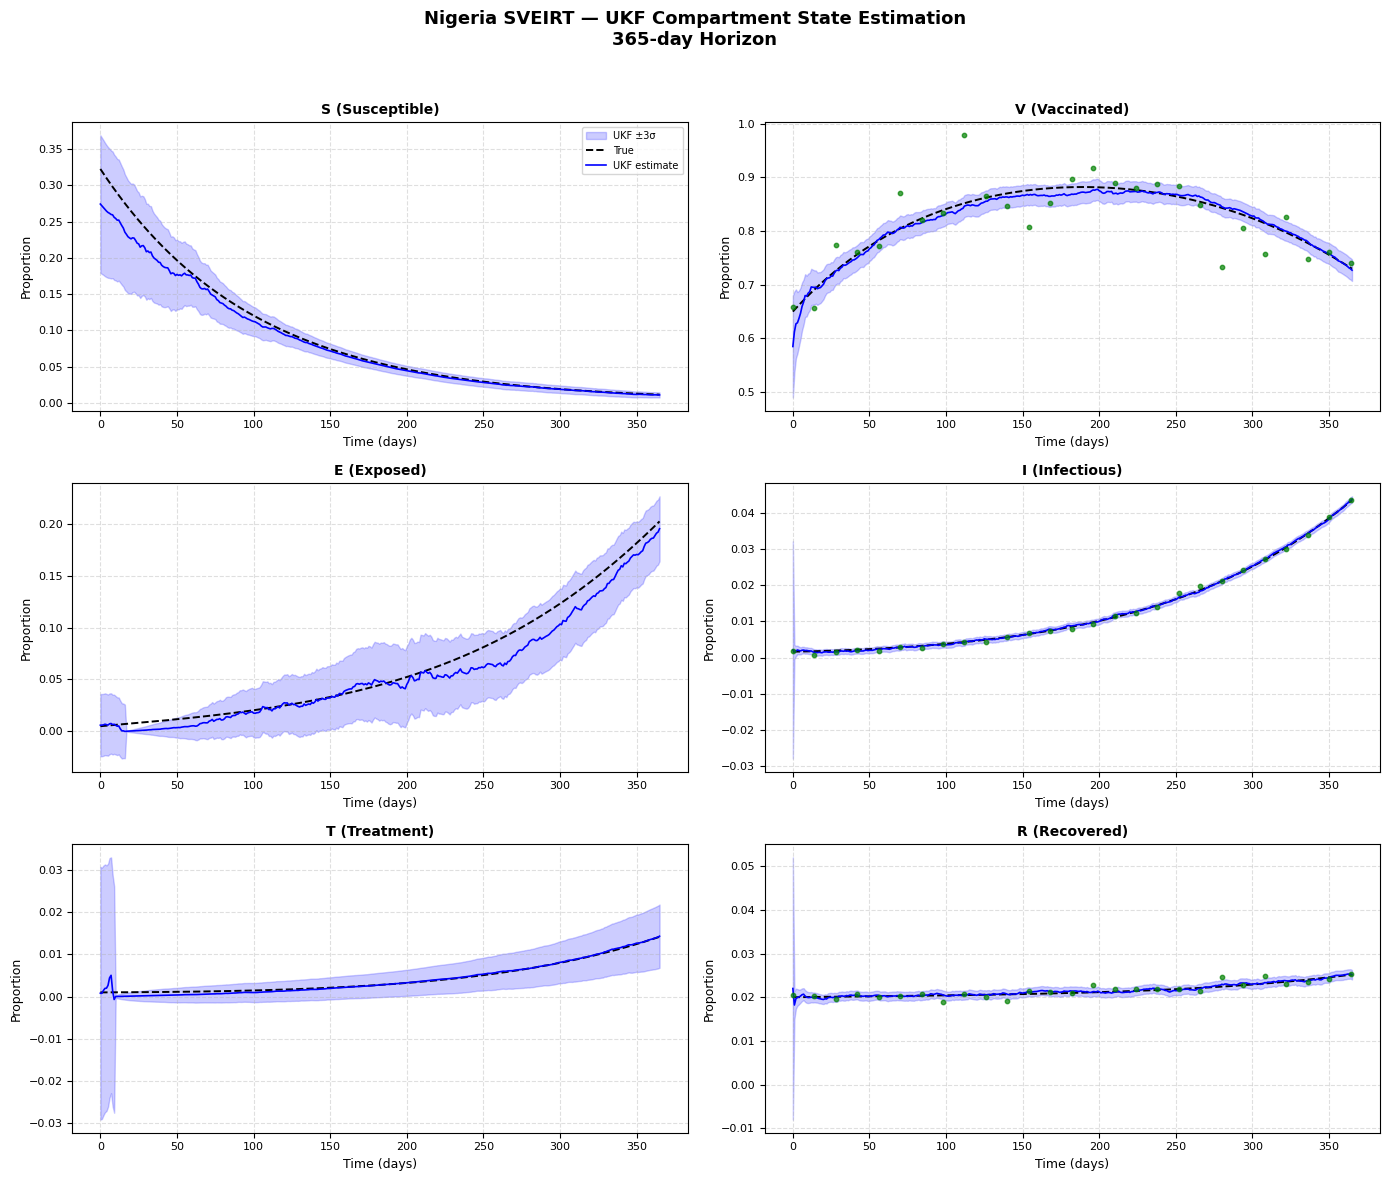

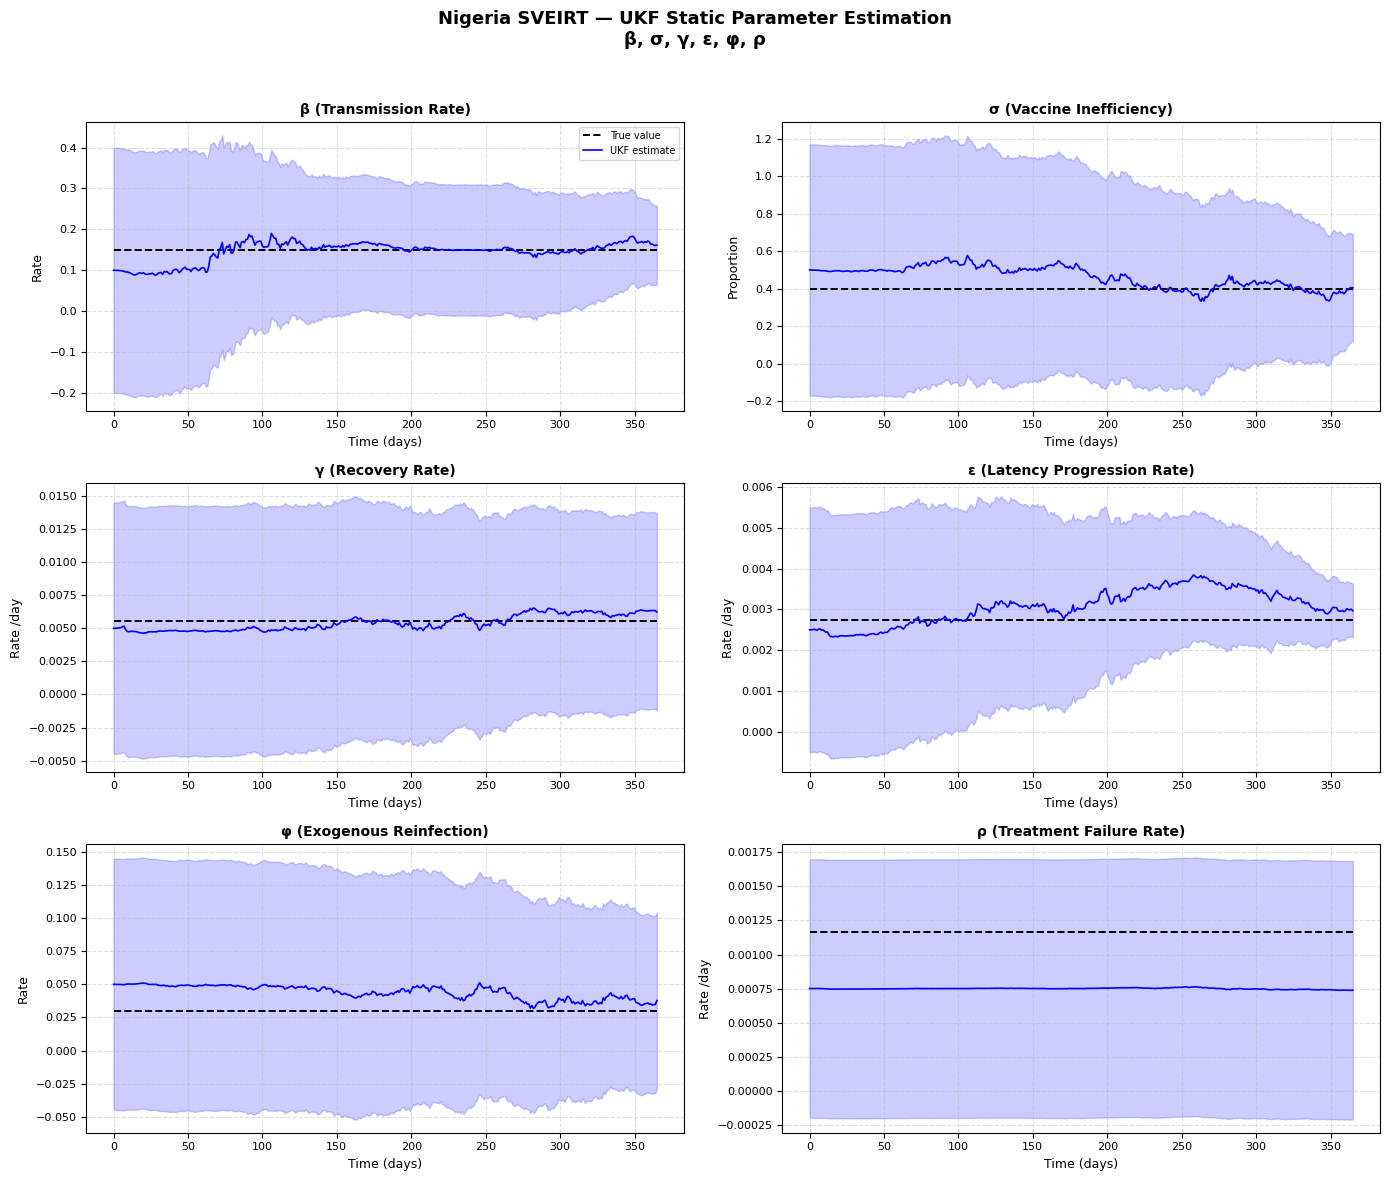

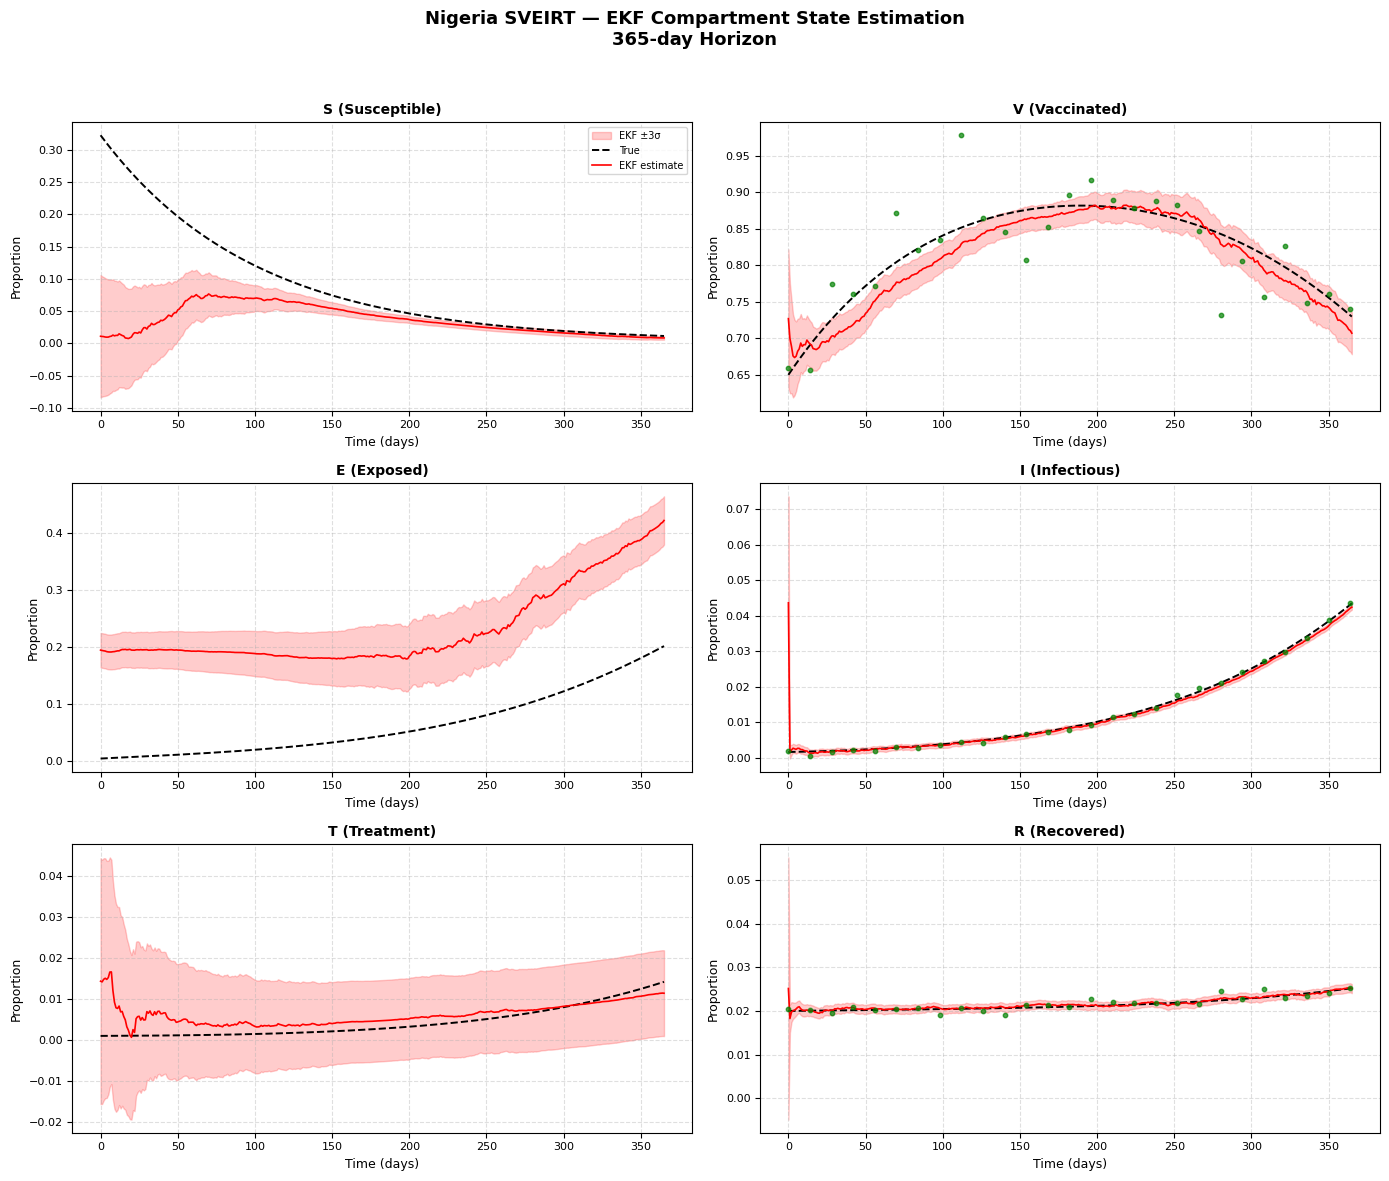

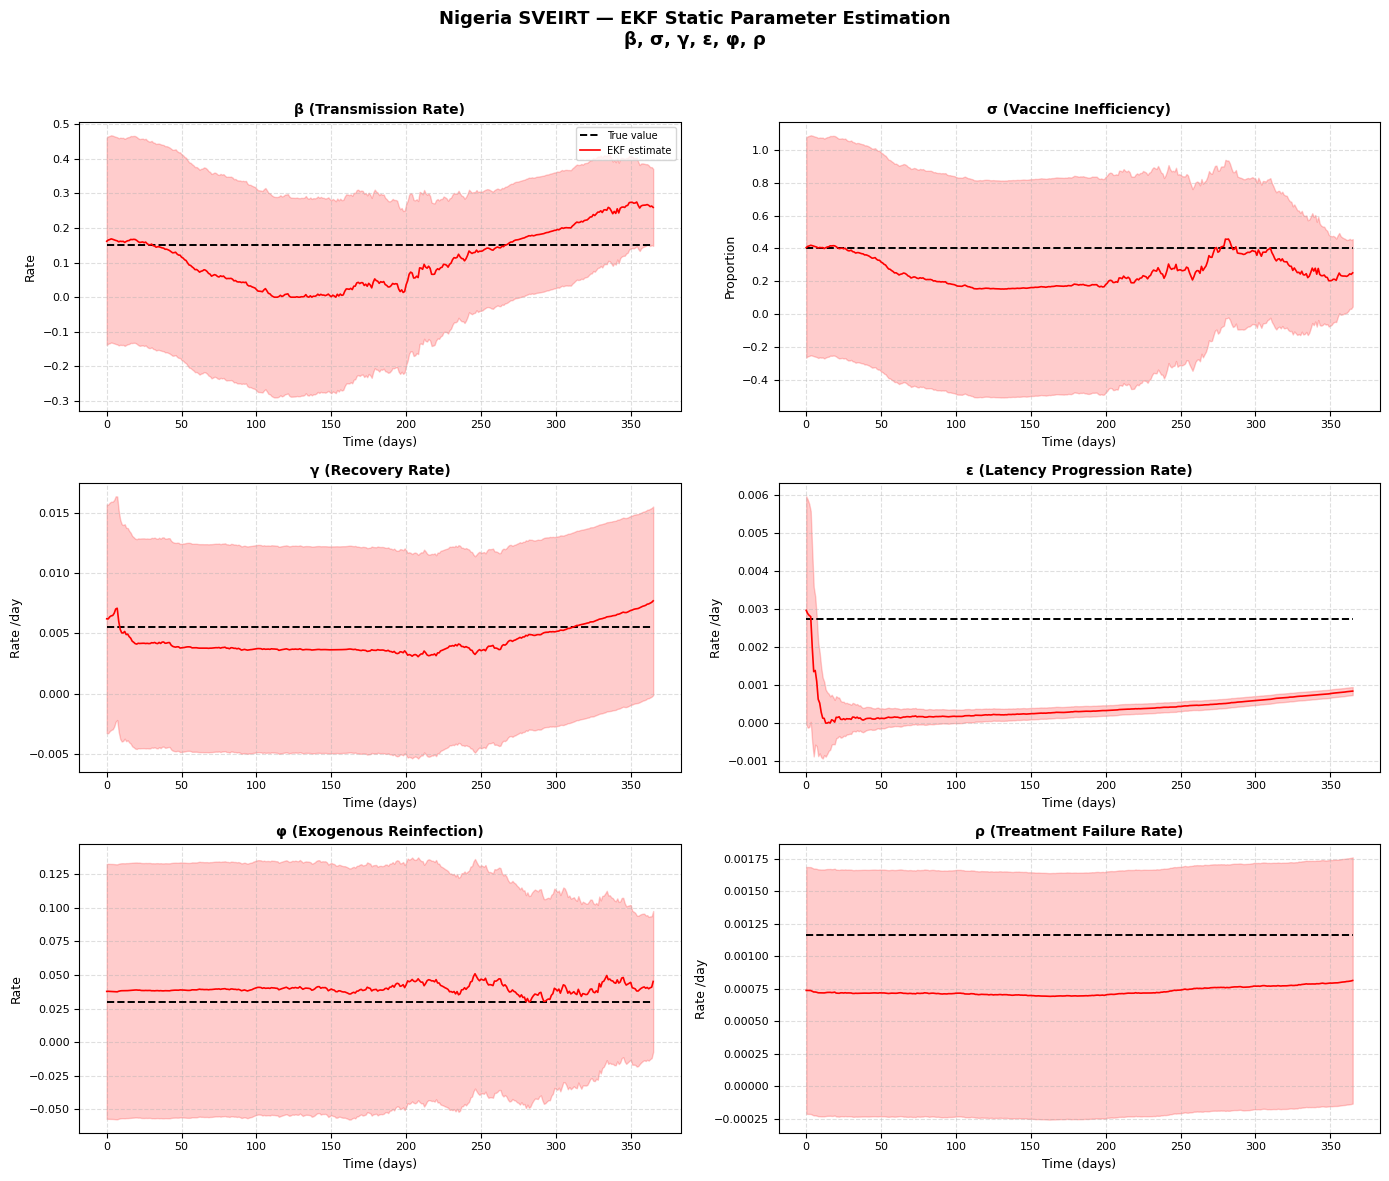

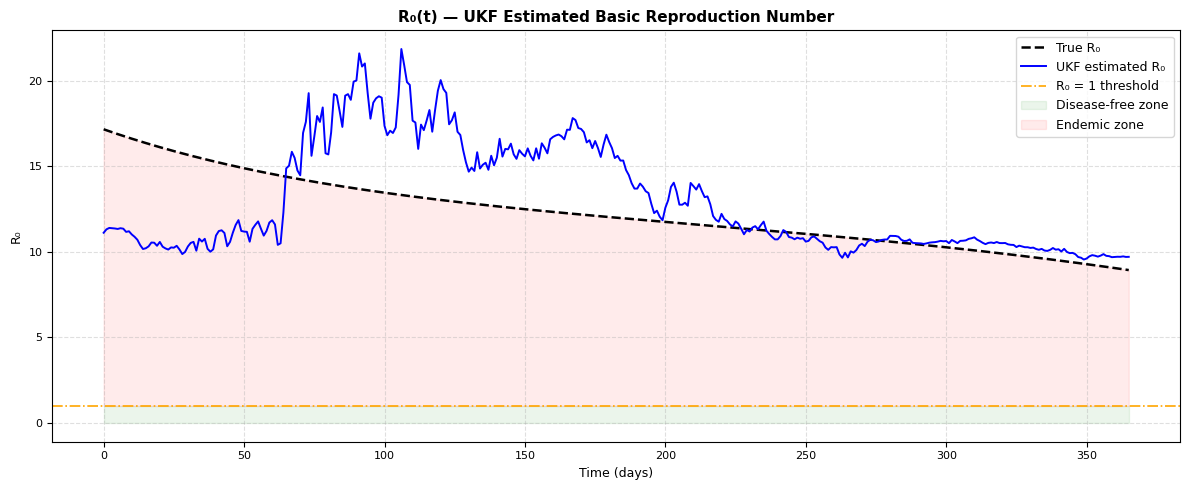

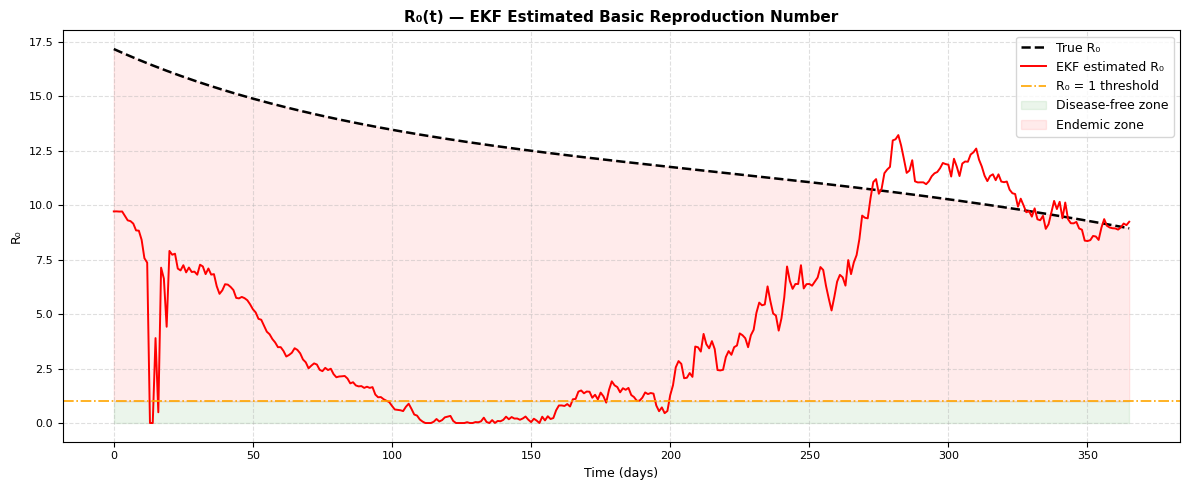

In [45]:
def style_ax(ax, title, ylabel=""):
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_xlabel("Time (days)", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

compartments = [
    (0, "S (Susceptible)",  S_true,  x_ukf[0], x_ekf[0], P_ukf[0], P_ekf[0], None),
    (1, "V (Vaccinated)",   V_true,  x_ukf[1], x_ekf[1], P_ukf[1], P_ekf[1], Y_meas[1]),
    (2, "E (Exposed)",      E_true,  x_ukf[2], x_ekf[2], P_ukf[2], P_ekf[2], None),
    (3, "I (Infectious)",   I_true,  x_ukf[3], x_ekf[3], P_ukf[3], P_ekf[3], Y_meas[0]),
    (4, "T (Treatment)",    T_true,  x_ukf[4], x_ekf[4], P_ukf[4], P_ekf[4], None),
    (5, "R (Recovered)",    R_true,  x_ukf[5], x_ekf[5], P_ukf[5], P_ekf[5], Y_meas[2]),
]

params_plot = [
    (6,  "β (Transmission Rate)",        beta_true,  "Rate"),
    (7,  "σ (Vaccine Inefficiency)",     sigma_true, "Proportion"),
    (8,  "γ (Recovery Rate)",            gamma_true, "Rate /day"),
    (9,  "ε (Latency Progression Rate)", eps_true,   "Rate /day"),
    (10, "φ (Exogenous Reinfection)",    phi_true,   "Rate"),
    (11, "ρ (Treatment Failure Rate)",   rho_true,   "Rate /day"),
]

# ══════════════════════════════════════════════════════════════════════════════
#  UKF PLOTS
# ══════════════════════════════════════════════════════════════════════════════

# UKF — Compartment States
fig1, axes = plt.subplots(3, 2, figsize=(14, 12))
fig1.suptitle("Nigeria SVEIRT — UKF Compartment State Estimation\n365-day Horizon",
              fontsize=13, fontweight='bold', y=0.98)

for idx, (i, title, true_, ukf_, ekf_, pu, pe, meas_) in enumerate(compartments):
    row, col = divmod(idx, 2)
    ax = axes[row][col]
    sigma3 = 3 * np.sqrt(np.abs(pu))
    ax.fill_between(t_eval, ukf_ - sigma3, ukf_ + sigma3,
                    alpha=0.2, color='blue', label="UKF ±3σ")
    if meas_ is not None:
        ax.scatter(t_eval[::14], meas_[::14], s=10, color='green',
                   alpha=0.7, label="Measurement", zorder=3)
    ax.plot(t_eval, true_, color='black', linewidth=1.4,
            linestyle='--', label="True")
    ax.plot(t_eval, ukf_,  color='blue',  linewidth=1.2, label="UKF estimate")
    style_ax(ax, title, "Proportion")
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# UKF — Static Parameters
fig2, axes2 = plt.subplots(3, 2, figsize=(14, 12))
fig2.suptitle("Nigeria SVEIRT — UKF Static Parameter Estimation\nβ, σ, γ, ε, φ, ρ",
              fontsize=13, fontweight='bold', y=0.98)

for idx, (i, title, true_val, ylabel_) in enumerate(params_plot):
    row, col = divmod(idx, 2)
    ax = axes2[row][col]
    true_line = np.full(n_steps, true_val)
    sigma3    = 3 * np.sqrt(np.abs(P_ukf[i]))
    ax.fill_between(t_eval, x_ukf[i] - sigma3, x_ukf[i] + sigma3,
                    alpha=0.2, color='blue')
    ax.plot(t_eval, true_line, color='black', linewidth=1.4,
            linestyle='--', label="True value")
    ax.plot(t_eval, x_ukf[i], color='blue',  linewidth=1.2, label="UKF estimate")
    style_ax(ax, title, ylabel_)
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
#  EKF PLOTS
# ══════════════════════════════════════════════════════════════════════════════

# EKF — Compartment States
fig3, axes3 = plt.subplots(3, 2, figsize=(14, 12))
fig3.suptitle("Nigeria SVEIRT — EKF Compartment State Estimation\n365-day Horizon",
              fontsize=13, fontweight='bold', y=0.98)

for idx, (i, title, true_, ukf_, ekf_, pu, pe, meas_) in enumerate(compartments):
    row, col = divmod(idx, 2)
    ax = axes3[row][col]
    sigma3 = 3 * np.sqrt(np.abs(pe))
    ax.fill_between(t_eval, ekf_ - sigma3, ekf_ + sigma3,
                    alpha=0.2, color='red', label="EKF ±3σ")
    if meas_ is not None:
        ax.scatter(t_eval[::14], meas_[::14], s=10, color='green',
                   alpha=0.7, label="Measurement", zorder=3)
    ax.plot(t_eval, true_, color='black', linewidth=1.4,
            linestyle='--', label="True")
    ax.plot(t_eval, ekf_,  color='red',   linewidth=1.2, label="EKF estimate")
    style_ax(ax, title, "Proportion")
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# EKF — Static Parameters
fig4, axes4 = plt.subplots(3, 2, figsize=(14, 12))
fig4.suptitle("Nigeria SVEIRT — EKF Static Parameter Estimation\nβ, σ, γ, ε, φ, ρ",
              fontsize=13, fontweight='bold', y=0.98)

for idx, (i, title, true_val, ylabel_) in enumerate(params_plot):
    row, col = divmod(idx, 2)
    ax = axes4[row][col]
    true_line = np.full(n_steps, true_val)
    sigma3    = 3 * np.sqrt(np.abs(P_ekf[i]))
    ax.fill_between(t_eval, x_ekf[i] - sigma3, x_ekf[i] + sigma3,
                    alpha=0.2, color='red')
    ax.plot(t_eval, true_line, color='black', linewidth=1.4,
            linestyle='--', label="True value")
    ax.plot(t_eval, x_ekf[i], color='red',   linewidth=1.2, label="EKF estimate")
    style_ax(ax, title, ylabel_)
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
#  R₀ TIME SERIES — UKF and EKF Separate
# ══════════════════════════════════════════════════════════════════════════════

# UKF R0
fig5, ax5 = plt.subplots(figsize=(12, 5))
ax5.plot(t_eval, R0_true, color='black', linewidth=1.8,
         linestyle='--', label="True R₀")
ax5.plot(t_eval, R0_ukf,  color='blue',  linewidth=1.4, label="UKF estimated R₀")
ax5.axhline(1.0, color='orange', linewidth=1.2, linestyle='-.', label="R₀ = 1 threshold")
ax5.fill_between(t_eval, 0, 1,       alpha=0.08, color='green', label='Disease-free zone')
ax5.fill_between(t_eval, 1, R0_true, alpha=0.08, color='red',
                 where=R0_true > 1, label='Endemic zone')
ax5.set_title("R₀(t) — UKF Estimated Basic Reproduction Number", fontsize=11, fontweight='bold')
ax5.set_xlabel("Time (days)", fontsize=9)
ax5.set_ylabel("R₀", fontsize=9)
ax5.tick_params(labelsize=8)
ax5.grid(True, linestyle='--', alpha=0.4)
ax5.legend(fontsize=9)
plt.tight_layout()
plt.show()

# EKF R0
fig6, ax6 = plt.subplots(figsize=(12, 5))
ax6.plot(t_eval, R0_true, color='black', linewidth=1.8,
         linestyle='--', label="True R₀")
ax6.plot(t_eval, R0_ekf,  color='red',   linewidth=1.4, label="EKF estimated R₀")
ax6.axhline(1.0, color='orange', linewidth=1.2, linestyle='-.', label="R₀ = 1 threshold")
ax6.fill_between(t_eval, 0, 1,       alpha=0.08, color='green', label='Disease-free zone')
ax6.fill_between(t_eval, 1, R0_true, alpha=0.08, color='red',
                 where=R0_true > 1, label='Endemic zone')
ax6.set_title("R₀(t) — EKF Estimated Basic Reproduction Number", fontsize=11, fontweight='bold')
ax6.set_xlabel("Time (days)", fontsize=9)
ax6.set_ylabel("R₀", fontsize=9)
ax6.tick_params(labelsize=8)
ax6.grid(True, linestyle='--', alpha=0.4)
ax6.legend(fontsize=9)
plt.tight_layout()
plt.show()